In [ ]:
# extract 10 frames from each video and concatenane them together
# even 10 frames

In [1]:
import pytorchcv
import cv2
import numpy as np
import glob
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
import os
import time

In [184]:
class BlazeFaceExtractor:
    ''' Convenient class'''
    
    
    def __init__(self):
        ''' load face extractor ''' 
        
        self.w_path = '/Users/dph/downloads/BlazeFace-PyTorch/blazeface.pth'
        self.a_path = '/Users/dph/downloads/BlazeFace-PyTorch/anchors.npy'
        self.f_path = '/Users/dph/downloads/BlazeFace-PyTorch/'
        
        import sys
        sys.path.insert(0, self.f_path)
        from blazeface import BlazeFace

        self.net = BlazeFace()
        self.net.load_weights(self.w_path)
        self.net.load_anchors(self.a_path)
   
            

        # Optionally change the thresholds:
        self.net.min_score_thresh = 0.75
        self.net.min_suppression_threshold = 0.3
        
        

    def extract_faces(self, frames = None, output_size=500):
        '''
        Arguments
            video_path: full path for one video
        '''
        self.output_size = output_size

        # 1 - tile
        tiles_frames, tiles_resize_info = self.tile_frames(frames)
        
        # 2 - predict
        detections = self.net.predict_on_batch(tiles_frames, apply_nms=False)
        
        # 3 - resize detection
        detections_resized = self.resize_detections(detections, self.net.input_size, tiles_resize_info)
        
        # 4 - untile
        frame_size = (frames.shape[2], frames.shape[1])
        detections_one = self.untile_detections(len(frames), frame_size, detections_resized)
        detections_one = self.net.nms(detections_one) # 
        
        # for each frame
        total_faces = []
        for i, detection_single in enumerate(detections_one):
            
            if len(detection_single) == 0:
                # no face, maybe too face is too small
                # use insightface instead
                continue
                
            elif len(detection_single) == 1:
                # 1 face
                pass
            
            elif len(detection_single) > 1:
                # multiple faces
                # misjudge or multi-characters?
                # 1 - only save one face by highest score
                # pro: can remove misjudge
                # con: remove multi-character too, but I don't care
                for d in detection_single:
                    score = max(detection_single[:, -1])
                    idx = np.where(detection_single[:,-1]==score)
                    detection_single = detection_single[idx]
                    
                
                # 2 - use facenet_pytorch to validate
                
            
            
            # 5 - add margin
            detections_margin = self.add_margin_to_detections(detection_single, frame_size=frame_size, margin=0.5)

            # 6 - crop
            faces_crop = self.crop_faces(frames[i], detections_margin)
            
            faces_final = []
            for face in faces_crop:
                # 7 - resize
                face_resized = self.isotropically_resize_image(face, self.output_size)
            
                # 8 - fill blank
                face_final = self.make_square_image(face_resized)
                faces_final.append(face_final)
            total_faces.append(faces_final)
        return total_faces
                
    
    
    def tile_frames(self, frames):
        target_size = (128, 128)
        
        num_frames, H, W, _ = frames.shape

        split_size = min(H, W)
        x_step = (W - split_size) // 2
        y_step = (H - split_size) // 2
        num_v = 1
        num_h = 3 if W > H else 1

        splits = np.zeros((num_frames * num_v * num_h, target_size[1], target_size[0], 3), dtype=np.uint8)

        i = 0
        for f in range(num_frames):
            y = 0
            for v in range(num_v):
                x = 0
                for h in range(num_h):
                    crop = frames[f, y:y+split_size, x:x+split_size, :]
                    splits[i] = cv2.resize(crop, target_size, interpolation=cv2.INTER_AREA)
                    x += x_step
                    i += 1
                y += y_step

        resize_info = [split_size / target_size[0], split_size / target_size[1]]
        return splits, resize_info
    
    
    
    def resize_detections(self, detections, target_size, resize_info):
        '''get detections from [0, 1] to original frame size (1080, 1080)'''

        projected = []
        target_w, target_h = target_size  # (128, 128)
        scale_w, scale_h = resize_info #  (1080/128, 1080/128)

        # each frame
        for i in range(len(detections)):
            detection = detections[i].clone()

            # ymin, xmin, ymax, xmax
            for k in range(2): #0, 1
                detection[:, k*2    ] = (detection[:, k*2    ] * target_h) * scale_h
                detection[:, k*2 + 1] = (detection[:, k*2 + 1] * target_w) * scale_w

            # keypoints are x,y
            for k in range(2, 8):
                detection[:, k*2    ] = (detection[:, k*2    ] * target_w) * scale_w
                detection[:, k*2 + 1] = (detection[:, k*2 + 1] * target_h) * scale_h

            projected.append(detection)

        return projected 
    
    
    
    def untile_detections(self, num_frames, frame_size, detections):
        """With N tiles per frame, there also are N times as many detections.
        This function groups together the detections for a given frame; it is
        the complement to tile_frames().
        detections: (192, ?, 17)
        """
        combined_detections = []

        W, H = frame_size
        split_size = min(H, W)
        x_step = (W - split_size) // 2
        y_step = (H - split_size) // 2
        num_v = 1
        num_h = 3 if W > H else 1

        i = 0
        for f in range(num_frames):
            detections_for_frame = []
            y = 0
            for v in range(num_v):
                x = 0
                for h in range(num_h):
                    # Adjust the coordinates based on the split positions.
                    detection = detections[i].clone()
                    if detection.shape[0] > 0:
                        for k in range(2):
                            detection[:, k*2    ] += y
                            detection[:, k*2 + 1] += x
                        for k in range(2, 8):
                            detection[:, k*2    ] += x
                            detection[:, k*2 + 1] += y

                    detections_for_frame.append(detection)
                    x += x_step
                    i += 1
                y += y_step

            combined_detections.append(torch.cat(detections_for_frame))

        return combined_detections
        
        
        
    def add_margin_to_detections(self, detections, frame_size, margin=0.2):
        """Expands the face bounding box.

        NOTE: The face detections often do not include the forehead, which
        is why we use twice the margin for ymin.

        Arguments:
            detections: a PyTorch tensor of shape (num_detections, 17)
            frame_size: maximum (width, height)
            margin: a percentage of the bounding box's height

        Returns a PyTorch tensor of shape (num_detections, 17).
        """
        offset = torch.round(margin * (detections[:, 2] - detections[:, 0])) # (ymax - ymin)*margin
        detections = detections.clone()
        detections[:, 0] = torch.clamp(detections[:, 0]-offset, min=0)            # ymin
        detections[:, 1] = torch.clamp(detections[:, 1]-offset, min=0)              # xmin
        detections[:, 2] = torch.clamp(detections[:, 2]+offset, max=frame_size[1])  # ymax
        detections[:, 3] = torch.clamp(detections[:, 3]+offset, max=frame_size[0])  # xmax
        
        # make square
        ymin = detections[:, 0]
        xmin = detections[:, 1]
        ymax = detections[:, 2]
        xmax = detections[:, 3]
        h = ymax-ymin
        w = xmax-xmin
        size = max(h, 2)
        if h < size:
            pad = (size-h)//2
            ymin = torch.clamp(ymin - pad, min=0)
            ymax = torch.clamp(ymax + pad, max=frame_size[1])
        if w < size:
            pad = (size-w)//2
            xmin = torch.clamp(xmin - pad, min=0)
            xmax = torch.clamp(xmax + pad, max=frame_size[0])
        
        # adjust boundary
        h = ymax-ymin
        w = xmax-xmin
        size = max(h, 2)
        if h < size:
            pad = size - h
            if xmin == 0:
                xmax = torch.clamp(xmax + pad, max=frame_size[0])
            if xmax == frame_size[0]:
                xmin = torch.clamp(xmin - pad, min=0)
            
        if w < size:
            pad = size - w
            if ymin == 0:
                ymax = torch.clamp(ymax + pad, max=frame_size[1])
            if ymax == frame_size[1]:
                ymin = torch.clamp(ymin - pad, min=0)
            
        detections[:, 0] = ymin
        detections[:, 1] = xmin
        detections[:, 2] = ymax
        detections[:, 3] = xmax
        
        return detections


      
    def crop_faces(self, frame, detections):
        """Copies the face region(s) from the given frame into a set
        of new NumPy arrays.

        Arguments:
            frame: a NumPy array of shape (H, W, 3)
            detections: a PyTorch tensor of shape (num_detections, 17)

        Returns a list of NumPy arrays, one for each face crop. If there
        are no faces detected for this frame, returns an empty list.
        """
        faces = []
        for i in range(len(detections)):
            ymin, xmin, ymax, xmax = detections[i, :4].cpu().numpy().astype(np.int)
            face = frame[ymin:ymax, xmin:xmax, :]
            faces.append(face)
        return faces
        
        
        
    def isotropically_resize_image(self, img, size, resample=cv2.INTER_AREA):
        h, w = img.shape[:2]
        if w > h:
            h = h * size // w
            w = size
        else:
            w = w * size // h
            h = size

        resized = cv2.resize(img, (w, h), interpolation=resample)
        return resized
    
        
    def make_square_image(self, img):
        h, w = img.shape[:2]
        size = max(h, w)
        t = 0
        b = size - h
        l = 0
        r = size - w
        return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [150]:
output_dir = 'outputs/'

In [151]:
df = pd.read_csv('all_metas_path.csv')
video_path = np.unique(df.name_path.values.astype('str'))
video_path = video_path[:-1] # last is nan
print(len(video_path))

119146


In [ ]:
trunk0 = glob.glob('/Users/dph/downloads/data-deepfake/dfdc_train_part_0/*.mp4')
trunk0 = [t[35:] for t in trunk0]
prefix = '/Users/dph/downloads/data-deepfake/'

In [143]:
def read_videos(video_path):
    v_cap = cv2.VideoCapture(video_path)
    v_int = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    idxes = np.linspace(0, v_int-1, 10, endpoint=True, dtype=np.int)
    frames = []
    
    for i in range(v_int):
        ret = v_cap.grab()
        
        if i in idxes:
            ret, frame = v_cap.retrieve()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        
    return np.array(frames)
         

In [144]:
frames = read_videos(os.path.join(prefix, trunk0[0]))
frames.shape

(10, 1920, 1080, 3)

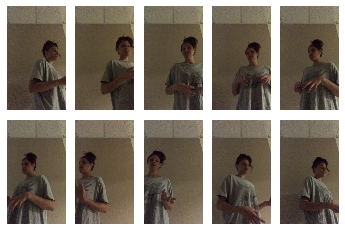

In [145]:
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(frames[i*5+j])
        ax[i][j].axis('off')

In [187]:
net_blaze = BlazeFaceExtractor()
faces = net_blaze.extract_faces(frames)

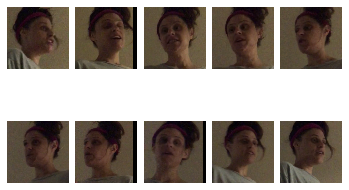

In [188]:
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(faces[i*5+j][0])
        ax[i][j].axis('off')

In [ ]:
# Code begins here

In [242]:
def save_faces(frames, video_name):
    
    # make directory
    output_dir = os.path.join('./output/', video_name[:-4])
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for i, faces in enumerate(frames):
        for j, f in enumerate(faces):
            img_name = video_name[-14:-4]+'_'+str(i)+'_'+str(j) + '.jpg'
            cv2.imwrite(os.path.join(output_dir, img_name), cv2.cvtColor(f, cv2.COLOR_RGB2BGR))

In [248]:
def extract_faces(num):
    trunk = glob.glob('/Users/dph/downloads/data-deepfake/dfdc_train_part_'+str(num)+'/*.mp4')
    trunk = [t[35:] for t in trunk]
    prefix = '/Users/dph/downloads/data-deepfake/'
    
    for i in tqdm(range(len(trunk))):
        frames = read_videos(os.path.join(prefix, trunk[i]))
        faces = net_blaze.extract_faces(frames, output_size=380)
        save_faces(faces, trunk[i])


In [249]:
for i in range(1, 50):
    extract_faces(i)